In [1]:
import sys
import os

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), ".."))
from project.graph_utils import get_graph_data, get_graph_by_name
from project.regular_path_query import tensor_based_rpq, ms_bfs_based_rpq
from scipy import sparse
import cfpq_data

import sources directory


In [2]:
MATRIX_TYPES = [
    sparse.csr_matrix,
    sparse.csc_matrix,
    sparse.lil_matrix,
    sparse.coo_matrix,
]

ALGORITHMS = [tensor_based_rpq, ms_bfs_based_rpq]
RUN_COUNT = 25
START_SET_FRACTIONS = [1, 0.7, 0.5, 0.3, 0.1]

In [3]:
def generate_start_set(graph, fraction):
    if fraction == 1:
        return set()
    nodes_count = max(1, int(graph.number_of_nodes() * fraction))
    return cfpq_data.generate_multiple_source(graph, nodes_count, seed=52)


def label_set_to_regexes(labels):
    a = labels[0]
    b = labels[1]
    c = labels[2]
    d = labels[3]
    return (
        f"({a} | {b})* {c} {d}+",
        f"{a} ({b} | {c})* {d}+",
        f"(({a} | {b})+ {c})* {d}",
        f"(({c}+) | {a}) {b} {d}*",
    )

In [4]:
gtravel = get_graph_by_name("travel")
gwine = get_graph_by_name("wine")
gfunding = get_graph_by_name("funding")
GRAPHS = {"travel": gtravel, "wine": gwine, "funding": gfunding}

[2025-10-12 01:20:15]>INFO>Found graph with name='travel'
[2025-10-12 01:20:15]>INFO>Load archive graph_archive=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2025-10-12 01:20:15]>INFO>Unzip graph name='travel' to file graph=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2025-10-12 01:20:15]>INFO>Remove archive graph_archive=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2025-10-12 01:20:15]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x11edc5400> from path=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2025-10-12 01:20:15]>INFO>Found graph with name='wine'
[2025-10-12 01:20:15]>INFO>Load archive graph_

In [5]:
REGEXES = {}


def generate_regexes(gname):
    # getting most popular 4 labels
    labels_set = get_graph_data(gname).attributes
    popular_labels = sorted(labels_set)[:4]
    return label_set_to_regexes(popular_labels)


for gname, _ in GRAPHS.items():
    REGEXES[gname] = generate_regexes(gname)

[2025-10-12 01:20:22]>INFO>Found graph with name='travel'
[2025-10-12 01:20:22]>INFO>Load archive graph_archive=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2025-10-12 01:20:22]>INFO>Unzip graph name='travel' to file graph=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2025-10-12 01:20:22]>INFO>Remove archive graph_archive=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2025-10-12 01:20:22]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x11ed0d0f0> from path=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2025-10-12 01:20:22]>INFO>Found graph with name='wine'
[2025-10-12 01:20:22]>INFO>Load archive graph_

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from itertools import product

In [13]:
OUTPUT_DIR = "experiment_out"
os.makedirs(OUTPUT_DIR, exist_ok=True)
RESULTS_CSV = os.path.join(OUTPUT_DIR, "experiment_res.csv")

In [14]:
def measure_time(graph, regex, start_nodes, matrix_type, algo):
    t0 = time.perf_counter()
    try:
        algo(
            regex=regex,
            graph=graph,
            start_nodes=start_nodes,
            final_nodes=set(graph.nodes()),
            matrix_class=matrix_type,
        )
    except Exception as e:
        print(f"ERROR in algo call: {e}")
        print(f"Algo details: {algo}")
        raise

    t1 = time.perf_counter()
    return t1 - t0


def run_experiment_for_graph(gname, graph):
    results = []
    for frac in START_SET_FRACTIONS:
        start_nodes = generate_start_set(graph, frac)
        for run in range(RUN_COUNT):
            for matrix_type, algo, regex in product(
                MATRIX_TYPES, ALGORITHMS, REGEXES[gname]
            ):
                matrix_type_name = matrix_type.__name__
                algo_name = algo.__name__
                elapsed = measure_time(graph, regex, start_nodes, matrix_type, algo)
                record = {
                    "graph": gname,
                    "regex": regex,
                    "matrix_type": matrix_type_name,
                    "algorithm": algo_name,
                    "fraction": frac,
                    "run": run,
                    "time": elapsed,
                    "start_set_size": len(start_nodes),
                }
                results.append(record)

                df = pd.DataFrame([record])
                df.to_csv(RESULTS_CSV, mode="a", index=False, header=False)
    return results


def run_all_experiments():
    all_results = []
    for gname, graph in GRAPHS.items():
        gresults = run_experiment_for_graph(gname, graph)
        all_results.extend(gresults)

    return pd.DataFrame(all_results)

In [16]:
df_results = run_all_experiments()

[2025-10-12 01:32:18]>INFO>Generate set of source vertices of 91 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x11edc5400> for multiple-source evaluation
[2025-10-12 01:34:26]>INFO>Generate set of source vertices of 65 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x11edc5400> for multiple-source evaluation
[2025-10-12 01:35:50]>INFO>Generate set of source vertices of 39 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x11edc5400> for multiple-source evaluation
[2025-10-12 01:36:44]>INFO>Generate set of source vertices of 13 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x11edc5400> for multiple-source evaluation
[2025-10-12 03:55:24]>INFO>Generate set of source vertices of 513 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x1068656d0> for multiple-source evaluation
[2025-10-12 05:03:48]>INFO>Generate set of source vertices of 366 nodes for graph=<networkx.classes.mult

In [ ]:
df_agg = (
    df_results.groupby(
        ["graph", "regex", "matrix_type", "algorithm", "fraction", "start_set_size"]
    )["time"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# df_agg['time_norm'] = df_agg.groupby(['graph', 'regex', 'fraction'])['mean'].transform(
#     lambda x: x / x.min()
# )

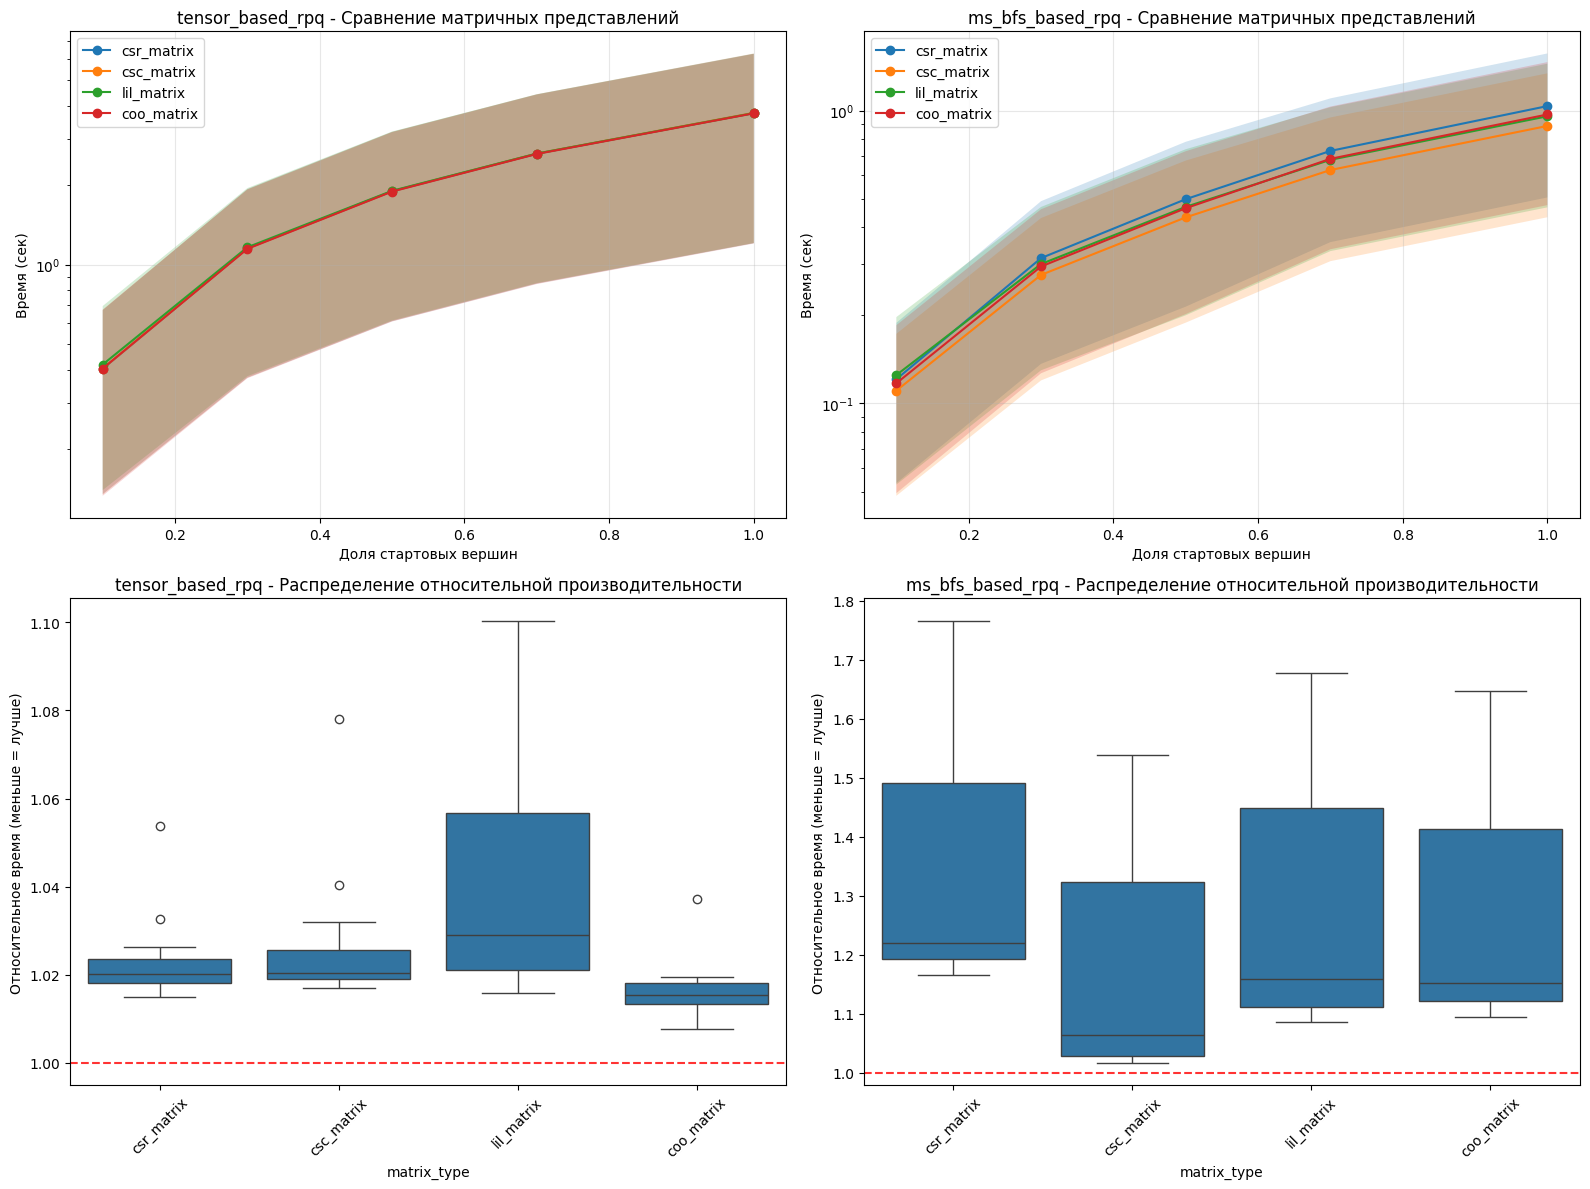

In [23]:
import seaborn as sns


def compare_matrix_types_per_algorithm():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Для каждого алгоритма отдельный анализ
    algorithms = ["tensor_based_rpq", "ms_bfs_based_rpq"]
    matrix_types = ["csr_matrix", "csc_matrix", "lil_matrix", "coo_matrix"]

    for i, algo in enumerate(algorithms):
        algo_data = df_results[df_results["algorithm"] == algo]

        # График 1: Время vs Доля стартовых вершин
        ax1 = axes[0, i]
        for matrix_type in matrix_types:
            matrix_data = algo_data[algo_data["matrix_type"] == matrix_type]
            avg_times = matrix_data.groupby("fraction")["time"].mean()
            std_times = matrix_data.groupby("fraction")["time"].std()

            ax1.plot(avg_times.index, avg_times.values, marker="o", label=matrix_type)
            ax1.fill_between(
                avg_times.index,
                avg_times.values - std_times.values,
                avg_times.values + std_times.values,
                alpha=0.2,
            )

        ax1.set_xlabel("Доля стартовых вершин")
        ax1.set_ylabel("Время (сек)")
        ax1.set_yscale("log")
        ax1.set_title(f"{algo} - Сравнение матричных представлений")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # График 2: Относительная производительность
        ax2 = axes[1, i]
        relative_perf = []
        for graph in algo_data["graph"].unique():
            graph_data = algo_data[algo_data["graph"] == graph]
            for frac in graph_data["fraction"].unique():
                frac_data = graph_data[graph_data["fraction"] == frac]
                min_time = frac_data["time"].min()
                for matrix_type in matrix_types:
                    mt_data = frac_data[frac_data["matrix_type"] == matrix_type]
                    if len(mt_data) > 0:
                        rel_time = mt_data["time"].mean() / min_time
                        relative_perf.append(
                            {
                                "matrix_type": matrix_type,
                                "relative_time": rel_time,
                                "graph": graph,
                                "fraction": frac,
                            }
                        )

        df_relative = pd.DataFrame(relative_perf)
        sns.boxplot(data=df_relative, x="matrix_type", y="relative_time", ax=ax2)
        ax2.axhline(
            1.0, color="red", linestyle="--", alpha=0.8, label="Лучший результат"
        )
        ax2.set_ylabel("Относительное время (меньше = лучше)")
        ax2.set_title(f"{algo} - Распределение относительной производительности")
        ax2.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()


compare_matrix_types_per_algorithm()

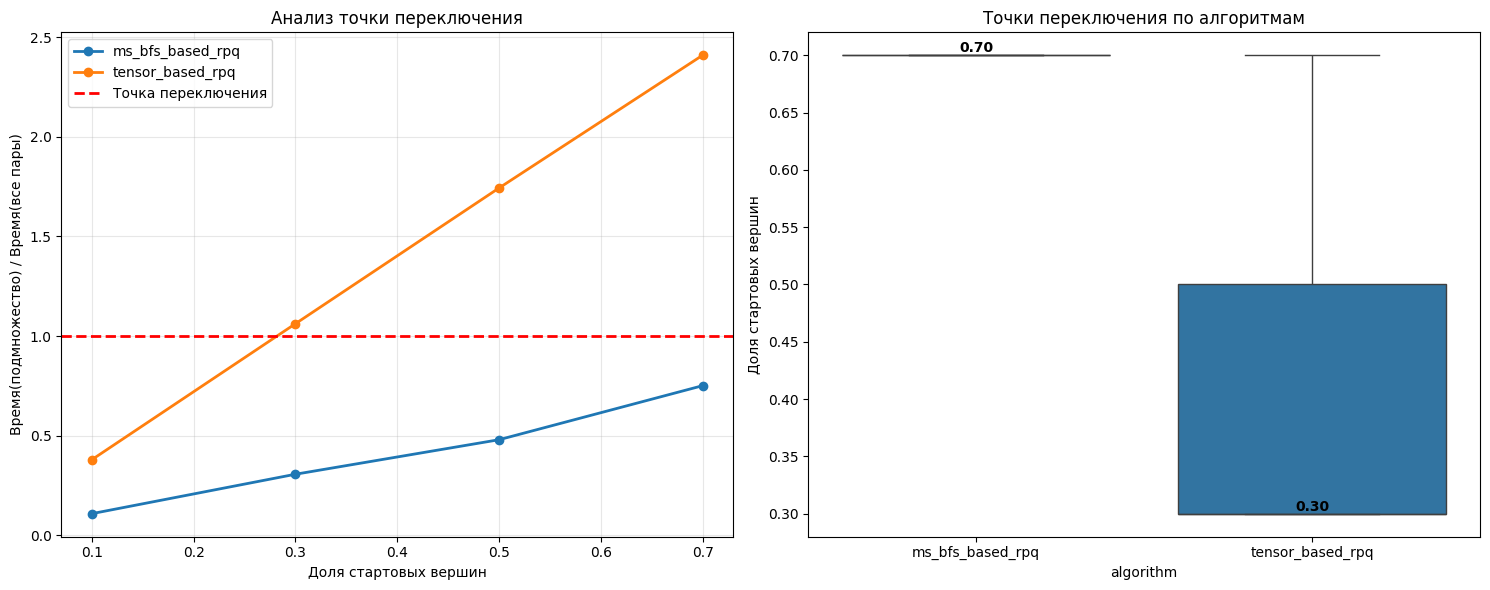

СТАТИСТИКА ТОЧЕК ПЕРЕКЛЮЧЕНИЯ:
ms_bfs_based_rpq:
  Медиана: 70.0%
  Среднее: 70.0%

tensor_based_rpq:
  Медиана: 30.0%
  Среднее: 43.3%



In [27]:
def analyze_crossover_simple():
    """Упрощенный анализ точки переключения"""

    # Получаем размеры графов
    graph_sizes = {gname: len(graph.nodes()) for gname, graph in GRAPHS.items()}

    crossover_results = []

    for graph in df_agg["graph"].unique():
        graph_data = df_agg[df_agg["graph"] == graph]
        total_nodes = graph_sizes[graph]

        # Время решения для всех пар (fraction=1.0)
        all_pairs_time = graph_data[graph_data["fraction"] == 1.0]["mean"].min()

        for algo in graph_data["algorithm"].unique():
            algo_data = graph_data[graph_data["algorithm"] == algo]

            # Ищем точку, где время для подмножества превышает время всех пар
            for frac in sorted(algo_data["fraction"].unique()):
                if frac == 1.0:
                    continue

                subset_time = algo_data[algo_data["fraction"] == frac]["mean"].min()

                crossover_results.append(
                    {
                        "graph": graph,
                        "algorithm": algo,
                        "fraction": frac,
                        "subset_time": subset_time,
                        "all_pairs_time": all_pairs_time,
                        "ratio": subset_time / all_pairs_time,
                        "is_crossover": subset_time > all_pairs_time,
                    }
                )

    df_crossover = pd.DataFrame(crossover_results)

    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # График 1: Отношение времени для каждого алгоритма
    for algo in df_crossover["algorithm"].unique():
        algo_data = df_crossover[df_crossover["algorithm"] == algo]
        mean_ratio = algo_data.groupby("fraction")["ratio"].mean()
        axes[0].plot(
            mean_ratio.index, mean_ratio.values, marker="o", label=algo, linewidth=2
        )

    axes[0].axhline(
        1.0, color="red", linestyle="--", linewidth=2, label="Точка переключения"
    )
    axes[0].set_xlabel("Доля стартовых вершин")
    axes[0].set_ylabel("Время(подмножество) / Время(все пары)")
    axes[0].set_title("Анализ точки переключения")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # График 2: Находим конкретные точки переключения
    crossover_points = []
    for graph in df_crossover["graph"].unique():
        for algo in df_crossover["algorithm"].unique():
            graph_algo_data = df_crossover[
                (df_crossover["graph"] == graph) & (df_crossover["algorithm"] == algo)
            ]

            # Находим первую точку переключения
            crossover = graph_algo_data[graph_algo_data["is_crossover"] == True]
            if not crossover.empty:
                first_crossover = crossover.iloc[0]
                crossover_points.append(
                    {
                        "graph": graph,
                        "algorithm": algo,
                        "crossover_fraction": first_crossover["fraction"],
                    }
                )
            else:
                # Если переключения не найдено, используем максимальную долю
                max_frac = graph_algo_data["fraction"].max()
                crossover_points.append(
                    {"graph": graph, "algorithm": algo, "crossover_fraction": max_frac}
                )

    df_crossover_summary = pd.DataFrame(crossover_points)

    if not df_crossover_summary.empty:
        sns.boxplot(
            data=df_crossover_summary, x="algorithm", y="crossover_fraction", ax=axes[1]
        )
        axes[1].set_ylabel("Доля стартовых вершин")
        axes[1].set_title("Точки переключения по алгоритмам")

        # Добавляем числовые значения
        for i, algo in enumerate(df_crossover_summary["algorithm"].unique()):
            median_val = df_crossover_summary[
                df_crossover_summary["algorithm"] == algo
            ]["crossover_fraction"].median()
            axes[1].text(
                i,
                median_val,
                f"{median_val:.2f}",
                ha="center",
                va="bottom",
                fontweight="bold",
            )

    plt.tight_layout()
    plt.show()

    # Вывод статистики
    print("СТАТИСТИКА ТОЧЕК ПЕРЕКЛЮЧЕНИЯ:")
    print("=" * 40)
    for algo in df_crossover_summary["algorithm"].unique():
        algo_data = df_crossover_summary[df_crossover_summary["algorithm"] == algo]
        median_frac = algo_data["crossover_fraction"].median()
        mean_frac = algo_data["crossover_fraction"].mean()
        print(f"{algo}:")
        print(f"  Медиана: {median_frac:.1%}")
        print(f"  Среднее: {mean_frac:.1%}")
        print()

    return df_crossover, df_crossover_summary


# Запускаем исправленную функцию
df_crossover, df_crossover_summary = analyze_crossover_simple()

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats

# RESULTS_CSV = "benchmark_results.csv"

# df = pd.DataFrame(RESULTS)
# df.to_csv(RESULTS_CSV, index=False)
# df.head()

# df = pd.read_csv(RESULTS_CSV)
# summary = (
#     df.groupby(["graph", "regex", "matrix_type", "algorithm", "fraction"])["time"]
#     .agg(["mean", "std", "count"])
#     .reset_index()
# )
# summary.head()


# def analyze_group(times, label="group"):
#     # times: numpy array of floats
#     times = np.array(times)
#     print(f"=== Analysis for {label} (n={len(times)}) ===")
#     # histogram
#     plt.figure(figsize=(5, 3))
#     plt.hist(times, bins=15)
#     plt.title(f"Histogram: {label}")
#     plt.xlabel("time (s)")
#     plt.ylabel("count")
#     plt.show()
#     # normality tests
#     if len(times) >= 3:
#         print("normaltest:", stats.normaltest(times))
#     if len(times) >= 3 and len(times) <= 5000:
#         print("shapiro:", stats.shapiro(times))
#     # mean and std (sample std)
#     mean = np.mean(times)
#     std = np.std(times, ddof=1) if len(times) > 1 else 0.0
#     print("mean:", mean, "std:", std, f"rel std: {100 * std / mean:.2f}%")
#     # confidence interval 95%
#     if len(times) > 1:
#         ci_half = stats.t.ppf(0.975, df=len(times) - 1) * stats.sem(times)
#         print("95% CI half-width:", ci_half)
#         print(f"{mean:.6f} ± {ci_half:.6f}")
#     return {"mean": mean, "std": std, "ci_half": (ci_half if len(times) > 1 else None)}


# # Example: analyze a specific combination (first row of summary)
# row = summary.iloc[0]
# sel = df[
#     (df.graph == row.graph)
#     & (df.regex == row.regex)
#     & (df.matrix_type == row.matrix_type)
#     & (df.algorithm == row.algorithm)
#     & (df.fraction == row.fraction)
# ]
# times = sel["time"].values
# analyze_group(
#     times, label=f"{row.graph}|{row.algorithm}|{row.matrix_type}|f={row.fraction}"
# )

# # Aggregate plots: time vs fraction for each algorithm+matrix_type
# for algo in df["algorithm"].unique():
#     plt.figure(figsize=(6, 3))
#     subset = df[df["algorithm"] == algo]
#     pivot = subset.groupby("fraction")["time"].mean().reindex(START_SET_FRACTIONS)
#     plt.plot(pivot.index, pivot.values, marker="o")
#     plt.title(f"Mean time vs fraction — {algo}")
#     plt.xlabel("fraction of start set")
#     plt.ylabel("mean time (s)")
#     plt.grid(True)
#     plt.show()

# # Save a compact summary CSV
# summary.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)